## compare bloom timing versus S3 ferry chl
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [2]:
Chl_N=1.8
pvars=['diatoms','flagellates','ciliates']
cdict={'diatoms':'darkgreen','flagellates':'mediumblue','ciliates':'maroon','+'.join(pvars):'k'}

In [3]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

In [4]:
df1=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20140804T234330Z_20150604T070614Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))
df2=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))
df=pd.concat([df1.drop(df1[df1.TimeUTC<'2015'].index),df2.drop(df2[df2.TimeUTC>'2016'].index)],ignore_index=True)

/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]

In [6]:
df=df.assign(dts=dts)

In [7]:
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

In [8]:
df.head()

,TimeUTC,CDOM,CDOMQC,Chlorophyll_ug,ChlQC,Turbidity_NTU,TurbQC,Lat,LatQC,Lon,LongQC,dts
0,2015-01-01T00:00:08.461Z,16.5912,1,1.2463,1,4.5548,1,49.094471,8,-123.426450,8,2015-01-01 00:00:08
1,2015-01-01T00:00:17.515Z,16.948,1,1.2342,1,4.7864,1,49.094835,8,-123.427538,8,2015-01-01 00:00:17
2,2015-01-01T00:00:27.689Z,16.7696,1,1.2221,1,4.632,1,49.095233,8,-123.428714,8,2015-01-01 00:00:27
3,2015-01-01T00:00:37.874Z,16.7696,1,1.3673,1,4.632,1,49.095742,8,-123.429833,8,2015-01-01 00:00:37
4,2015-01-01T00:00:48.048Z,16.948,1,1.2826,1,4.632,1,49.096250,8,-123.430950,8,2015-01-01 00:00:48


In [9]:
df['Lon'][0]

-123.42645043

In [10]:
places.PLACES['S3']

{'lon lat': (-123.558, 49.125),
 'NEMO grid ji': (450, 258),
 'GEM2.5 grid ji': (138, 144)}

In [11]:
111*.0226

2.5086

In [12]:
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(735599.0, 735842.0)

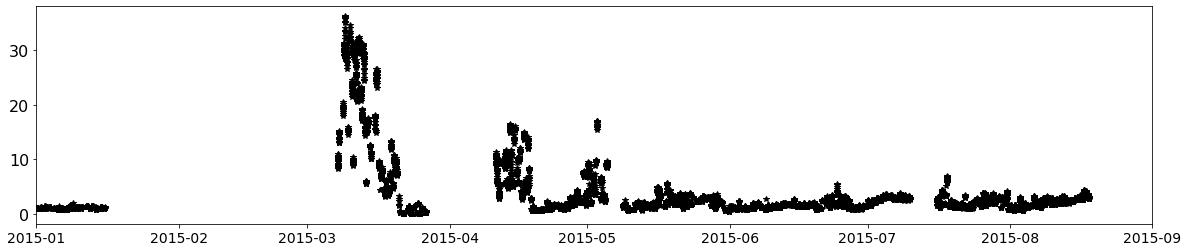

In [13]:
fig,ax=plt.subplots(1,1,figsize=(20,4))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'k*')
ax.set_xlim(dt.datetime(2015,1,1),dt.datetime(2015,9,1))

In [14]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

t0=dt.datetime(2015,2,6)
fdur=10 # length of each results file in days
fnum=18 # number of results files per run
runlen=fdur*fnum # length of run in days
#stm=np.shape(tmask)

In [26]:
sdir='/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812ESSMORT' # leave off trailing /!

In [28]:
flist=et.index_model_files_flex(basedir=sdir,ftype='ptrc_T',freq='1h',nam_fmt='long')

In [16]:
t0=dt.datetime.now()

In [17]:
dt.datetime.now()-t0

datetime.timedelta(microseconds=7538)

In [18]:
## extract timeseries for each lock
t0=dt.datetime.now()
times=list()
svals = {locname: {var: [] for var in pvars+['+'.join(pvars),]} for locname in plist} 
for fi in flist['paths']:
    print(fi)
    with nc.Dataset(fi) as f:
        torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
        times.append([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])
        tlen=len(f.variables['time_centered'][:])
        for iloc in plist:
            print(iloc)
            jj,ii=places.PLACES[iloc]['NEMO grid ji']
            e3tX=np.tile(e3t_0[:,:3,jj,ii],(tlen,1))
            e3tXsum=np.sum(e3tX,1)
            temp2=np.zeros(tlen)
            for var in pvars:
                print(var)
                temp=np.sum(f.variables[var][:,:3,jj,ii]*e3tX,1)/e3tXsum
                svals[iloc][var].append(temp)
                temp2=temp2+temp
                print(dt.datetime.now()-t0)
            svals[iloc]['+'.join(pvars)].append(temp2)
times=np.concatenate(times)
for iloc in plist:
    for var in pvars+['+'.join(pvars),]:
        svals[iloc][var]=np.concatenate(svals[iloc][var])

/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812ESSMORT/SalishSea_1h_20150101_20150120_ptrc_T_20150101-20150110.nc
Sentry Shoal
diatoms
0:00:37.757202
flagellates
0:01:15.331417
ciliates
0:01:52.797570
S3
diatoms
0:02:30.510068
flagellates
0:03:08.045843
ciliates
0:03:45.528289
Central node
diatoms
0:04:23.257236
flagellates
0:05:00.905921
ciliates
0:05:38.699954
Central SJDF
diatoms
0:06:16.749844
flagellates
0:06:54.634119
ciliates
0:07:32.508103
/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812ESSMORT/SalishSea_1h_20150101_20150120_ptrc_T_20150111-20150120.nc
Sentry Shoal
diatoms
0:21:29.739002
flagellates
0:32:48.739797
ciliates
0:44:22.534464
S3
diatoms
0:54:27.082416
flagellates
1:03:49.702651
ciliates
1:13:15.431888
Central node
diatoms
1:13:53.281002
flagellates
1:14:31.124397
ciliates
1:15:08.914916
Central SJDF
diatoms
1:15:46.815336
flagellates
1:16:24.673996
ciliates
1:17:02.992752
/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812ESSM

In [27]:
data={}
data['times']=times
data['series']=svals

with open(sdir+'_local/timeseries.pkl','wb') as f:
    pickle.dump(data,f)

In [22]:
xl=(times[0],times[-1])

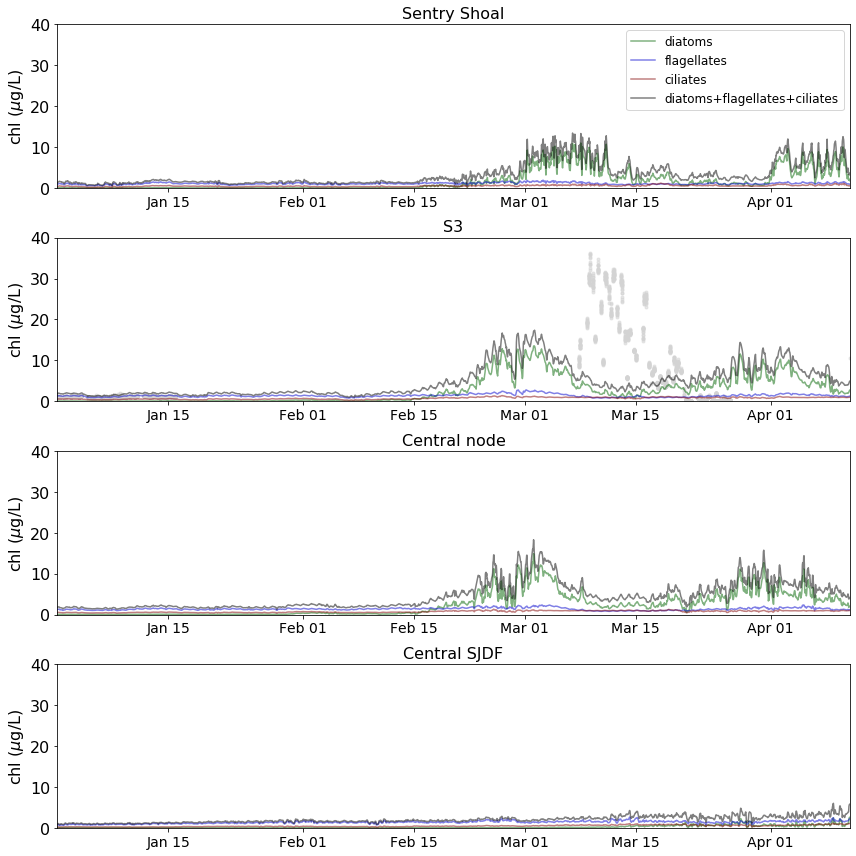

In [29]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist),1,figsize=(12,3*(len(plist))))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
    pp[ii]=dict()
    for var in pvars+['+'.join(pvars),]:
        pp[ii][var]=ax[ii].plot(times,Chl_N*svals[pl][var],
                      linestyle='-',color=cdict[var],alpha=.5,label=var)
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)

plt.tight_layout()

#ax[1].plot(dt.datetime(2015,3,21),5,'r*')

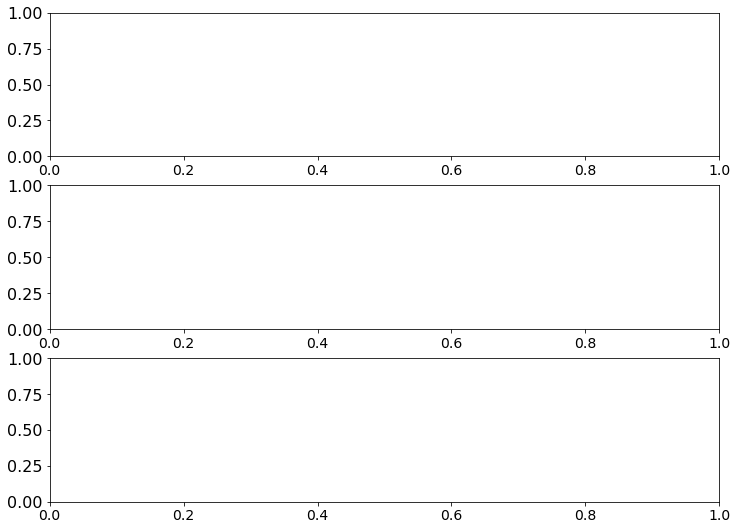

In [30]:
# diatoms, nitrogen
fig,ax=plt.subplots(3,1,figsize=(12,9))
ax[0].